In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

## 2. Gravitational Orbits in Cartesian Coordinates
>a. Make a notebook that solves the two body problems for gravitational attraction between two bodies in Cartesian coordinates. Implement the differential equations as a Python class.
<br>b. Show that the problem reduces to the orbits considered in class if one of the bodies is very heavy and you are in its rest frame.
<br>c. Add Markdown/LaTeX documentation.
<br>d. Use the Leapfrog method to solve the differential equations and show that it conserves energy while using the SciPy ODE solvers do not?
<br>e. Extend the simulation to three bodies in the same plane and comment on the orbits you find.
<br>f. Add widgets to control the simulation and/or animate the orbits.


Energy Within Two Body orbital Mechanics  
$\begin{align}
     T(\mathbf{\dot r}) &= \frac 12 \sum m_i(\dot x_i^2 + \dot y_2^2) \\
     U(\mathbf{r}) &= -\frac{G m_1 m_2}{\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}}
\end{align}$
 
 
The Lagrange's Equation:  
$\begin{align}
  \mathcal{L} &= T-U 
  \rightarrow \frac d{dt} \frac {\partial \mathcal L}{\partial\dot x_i}=\frac {\partial\mathcal L}{\partial x_i}  \\
\end{align}$

Energy Functions:  
$\begin{align}
  T &= \frac 12 (M\mathbf {\dot R}^2 + \mu \mathbf {\dot r}^2) \\
  U &= 
\end{align}$

In [2]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = k r^n.  Several algorithms for integration of 
    ordinary differential equations are now available. 
    """
    
    def __init__(self, ang_mom = 1, n = 1, k=1, m1=1., m2=1., G = 1.):
        #self.ang_mom = ang_mom
        #self.n = n
        #self.k = k
        #self.mu = m1*m2/(m1+m2)
        self.m1 = m1
        self.m2 = m2
        #self.M = m1 + m2 
        self.G = G
    
    def U(self, r):
        """Potential energy of the form U = kr^n."""
        return -self.G*self.m1*self.m2/r
    
    #def Ucf(self, r):
     #   """Centrifugal potential energy"""
      #  return self.ang_mom**2 / (2. * self.mu * r**2)
    
    #def Ueff(self, r):
     #   """Effective potential energy"""
      #  return self.U(r) + self.Ucf(r)
    
    def U_deriv(self, r):
        """dU/dr"""
        return self.G*self.m1*self.m2/r**2
        
    def Ucf_deriv(self, r):
        """dU_cf/dr"""
        return -2. * self.ang_mom**2 / (2. * self.mu * r**3)
        
    def Ueff_deriv(self, r):
        """dU_eff/dr"""
        return self.U_deriv(r) + self.Ucf_deriv(r)
        
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dy1/dt, d^2y1/dt^2 dx2/dt d^2x2/dt^2 
        dy2/dt, d^2y2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            3-component vector with y[0] = x1(t), y[1] = dx1/dt, 
                                    y[2] = y1(t), y[3] = dy1/dt,
                                    y[4] = x2(t), y[5] = dx2/dt, 
                                    y[6] = y2(t), y[7] = dy2/dt
            
        """
        G = self.G
        
        return [y[1], 
                -G*self.m2*((y[0]-y[4])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2)), 
                y[3], 
                -G*self.m2*((y[2]-y[6])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2)),
                y[5],
                G*self.m1*((y[0]-y[4])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2)),
                y[7],
                G*self.m1*((y[2]-y[6])*((y[0]-y[4])**2+(y[2]-y[6])**2)**(-3/2))]
    
    def solve_ode(self, t_pts, x_0, x_dot_0, y_0, y_dot_0, 
                  method='RK23', 
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions. To operate, give the function 
        the list of x_0, x_dot_0, y_0, and y_dot_0 where object 0 in the lists 
        is body 1. The function will output 4 sets of vectors in the given order. 
        Use solve_ivp with the option of specifying the method. Specify smaller 
        abserr and relerr to get more precision.
        """
        
        y = [x_0[0], x_dot_0[0], y_0[0], y_dot_0[0], 
             x_0[1], x_dot_0[1], y_0[1], y_dot_0[1]] 
                
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def solve_ode_Euler(self, t_pts, r_0, r_dot_0, phi_0):
        """
        Solve the ODE given initial conditions with the Euler method.
        The accuracy is determined by the spacing of times in t_pts.
        """
        
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, phi with zeros
        num_t_pts = len(t_pts)    # length of the array t_pts
        r = np.zeros(num_t_pts)
        r_dot = np.zeros(num_t_pts)
        phi = np.zeros(num_t_pts)
        
        # initial conditions
        r[0] = r_0
        r_dot[0] = r_dot_0
        phi[0] = phi_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [r[i], r_dot[i], phi[i]]
            r[i+1] = r[i] + self.dy_dt(t,y)[0] * delta_t
            r_dot[i+1] = r_dot[i] + self.dy_dt(t,y)[1] * delta_t 
            phi[i+1] = phi[i] + self.dy_dt(t,y)[2] * delta_t
        return r, r_dot, phi   
    
    
    def solve_ode_Leapfrog(self, t_pts, r_0, r_dot_0, phi_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        r = np.zeros(num_t_pts)
        r_dot = np.zeros(num_t_pts)
        r_dot_half = np.zeros(num_t_pts)
        phi = np.zeros(num_t_pts)
        
        # initial conditions
        r[0] = r_0
        r_dot[0] = r_dot_0
        phi[0] = phi_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [r[i], r_dot[i], phi[i]]
            r_dot_half[i] = r_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            r[i+1] = r[i] + r_dot_half[i] * delta_t
            
            y = [r[i+1], r_dot[i], phi[i]]
            r_dot[i+1] = r_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            
            phi[i+1] = phi[i] + self.dy_dt(t,y)[2] * delta_t
        return r, r_dot, phi   
        
    
    def energy(self, t_pts, r, r_dot):
        """Evaluate the energy as a function of time"""
        return (self.mu/2.) * r_dot**2 + self.Ueff(r)

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [29]:
t_start = 0.
t_end = 50.
delta_t = 0.001
t_pts = np.arange(t_start, t_end+delta_t, delta_t)

m1 = 1000.
m2 = 1000.
G =  .1#6.7 * 10**(-11)

a = 3
b = 1

x_0 = [a,-m1/m2*a]
x_dot_0 = [-b,m1/m2*b]
y_0 = [a, -m1/m2*a]
y_dot_0 = [b, -m1/m2*b]


o1 = Orbit(G=G, m1 = m1, m2 = m1)
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(t_pts, x_0, x_dot_0, y_0, y_dot_0)
com = np.array([(m1*x1+m2*x2)/(m1+m2), (m1*y1+m2*y2)/(m1+m2)])
print("done")

done


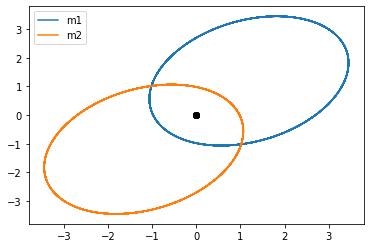

In [30]:
z = np.zeros(5)
plt.plot(x1-com[0], y1-com[1], label = "m1")
plt.plot(x2-com[0], y2-com[1], label = 'm2')
plt.plot(z,z, 'ok')
plt.legend()

In [31]:
# Labels for individual plot axes
x_vs_y_labels = (r'$x(t)$', r'$y(t)$')
#phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
#state_space_labels = (r'$\phi_1$', r'$d\phi_1/dt$')

fig = plt.figure(figsize=(10,5))
overall_title = 'Two Body System Orbits:  ' +  \
                 rf'  $ \mathbf {r}_1(0) = ({x_0[0]:.2f},{y_0[0]:.2f}),$' +  \
                 rf'  $ \mathbf {\dot r}_1(0) = ({x_dot_0[0]:.2f},{y_dot_0[0]:.2f}),$' +  \
                 rf'  $ \mathbf {r}_2(0) = ({x_0[1]:.2f},{y_0[1]:.2f}),$' +  \
                 rf'  $ \mathbf {\dot r}_2(0) = ({x_dot_0[1]:.2f},{y_dot_0[1]:.2f})$' 
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  

#start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1,y1, 
            axis_labels=x_vs_y_labels, 
            color='Orange',
            label=r'$\mathbf r_1(t)$', 
            #title=r'$\phi_1(t)$', 
            ax=ax_a)  
plot_y_vs_x(x2,y2, 
            axis_labels=x_vs_y_labels, 
            color='Purple',
            label=r'$\mathbf r_2(t)$', 
            #title=r'$\phi_2(t)$', 
            ax=ax_a) 

SyntaxError: f-string expression part cannot include a backslash (<ipython-input-31-518bfd946e5d>, line 9)